# Approximation through Distillation

## Initialisation

In [ ]:
!pip install numpy pandas scikit-learn transformers datasets evaluate tqdm matplotlib seaborn gensim nltk pm4py tensorflow tokenizers torch transformers tf-keras umap-learn

In [2]:
import os
import sys

# set PYTHONPATH to the src directory
sys.path.append('src')

from pm4py.objects.log.importer.xes import importer as xes_importer
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


variant = xes_importer.Variants.ITERPARSE
parameters = {
    #variant.value.Parameters.TIMESTAMP_SORT: True,
    #variant.value.Parameters.REVERSE_SORT: False,
}


## Create Log Statistics

In [7]:
from tapp.text_encoder import BoWTextEncoder, BERTbaseTextEncoder
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np

folder_names = ["bpi_2012_enriched_filtered_A", "werk"]

print("Load event log...")

print("Create log statistics...")
for folder_name in folder_names:
    if folder_name == "werk":
        path = "./data/werk.xes"
        data_attributes = ["age", "gender"]
        text_attribute = "question"
        text_models = [BERTbaseTextEncoder(encoding_length=768, language="english")]
    elif "bpi" in folder_name:
        path = f"./data/{folder_name}.xes"
        data_attributes = []
        if "special" in folder_name:
            text_attribute = "binary_flag"
        else:
            text_attribute = "text"
        text_models = [BERTbaseTextEncoder(encoding_length=768, language="english")]
    log = xes_importer.apply(path, variant=variant, parameters=parameters)

    language = "english"
    traces = len(log)
    events = sum(len(case) for case in log)
    durations = [(case[-1]["time:timestamp"].timestamp() - case[0]["time:timestamp"].timestamp()) / 86400 for case in log]
    docs = [event[text_attribute] for case in log for event in case if text_attribute in event]
    words = [word for doc in docs for word in word_tokenize(doc, language=language)]
    docs_filtered = BoWTextEncoder().preprocess_docs(docs, as_list=False)
    words_filtered = [word for doc in docs_filtered for word in word_tokenize(doc, language=language)]

    log_info = pd.DataFrame(
        [[path,
        traces,
        events,
        events / traces,
        np.median(durations),
        np.mean(durations),
        len(list(dict.fromkeys([event["concept:name"] for case in log for event in case])) if log else []),
        len(words),
        len(words_filtered),
        len(set(words)),
        len(set(words_filtered))]],
        columns=["log", "cases", "events", "events per trace", "median case duration",
                "mean case duration", "activities", "words pre filtering", "words post filtering",
                "vocabulary pre filtering", "vocabulary post filtering"]
    )

    log_info.to_csv(f"./data/log_info_{folder_name}.csv", index=False, sep=";")
print("Done.")

Load event log...
Create log statistics...


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Haspe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
parsing log, completed traces :: 100%|██████████| 13087/13087 [00:01<00:00, 9319.36it/s]
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Haspe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Haspe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
parsing log, completed traces :: 100%|██████████| 15001/15001 [00:03<00:00, 4829.14it/s]
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Haspe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Done.


## Create the Training Data

In [ ]:
# from pm4py.objects.log.importer.xes import importer as xes_importer
from tapp.tapp_model import _get_event_labels, TappModel
from tapp.log_encoder import LogEncoder
from tapp.tapp_model import TappModel, _get_event_labels
from tapp.text_encoder import BoWTextEncoder
from tapp.text_encoder import BoNGTextEncoder
from tapp.text_encoder import LDATextEncoder
from tapp.text_encoder import BERTbaseTextEncoder
from tapp.text_encoder import BERTbaseFineTunedNextActivityTextEncoder
from distillation import get_distillation_paths
import os
import numpy as np
import sys
from pm4py.objects.log.importer.xes import importer as xes_importer

runs = 3
folder_names = ["bpi_2012_enriched_special_filtered_A"]
folder_names = ["bpi_2012_enriched_special_filtered_A"]
folder_names = ["bpi_2012_enriched_event"]
folder_names = ["bpi_2012_enriched_filtered_A", "werk"]
folder_names = ["werk"]
force_recompute = True


for folder_name in folder_names:
    print("Processing folder:", folder_name)

    if folder_name == "werk":
        path = "./data/werk.xes"
        data_attributes = ["age", "gender"]
        text_attribute = "question"
        text_models = [BERTbaseTextEncoder(encoding_length=768, language="english")]
    elif "bpi" in folder_name:
        path = f"./data/{folder_name}.xes"
        data_attributes = []
        if "special" in folder_name:
            text_attribute = "binary_flag"
        else:
            text_attribute = "text"
        text_models = [BERTbaseTextEncoder(encoding_length=768, language="english")]

    print("usingtextattribute:", text_attribute)
    log = xes_importer.apply(path, variant=variant, parameters=parameters)
    activities = _get_event_labels(log, "concept:name")
    class_names = _get_event_labels(log, "concept:name")
    class_names.append("END")
    split = len(log) // 5 * 4
    train_log = log[:split]
    test_log = log[split:]

    for text_model in text_models:
        print(f"Using text model: {text_model.name} with encoding length {text_model.encoding_length}")

        # initialize and fit the log encoder
        log_encoder = LogEncoder(
            text_encoder=text_model,
            advanced_time_attributes=True,
            text_base_for_training="event",
        )
        print("Fitting log encoder...")
        log_encoder.fit(
            log,
            activities=activities,
            data_attributes=data_attributes,
            text_attribute=text_attribute,
        )

        print("Transforming training data...")
        X_train, y_train_act, y_train_time = log_encoder.transform(train_log, for_training=True)
        print("X_train shape:", X_train.shape)
        print("Transforming test data...")
        X_test, y_test, _ = log_encoder.transform(test_log, for_training=True)
        print("X_test shape:", X_test.shape)

        # tappbert original hyperparameters
        shared_layer = 1
        special_layer = 1
        neuron = 100
        epochs = 25
        # test for lars
        shared_layer = 2
        special_layer = 1
        neuron = 150
        epochs = 50

        for run_id in range(runs):
            distillation_path_train, distillation_path_test = get_distillation_paths(folder_name, text_model, data_attributes, text_attribute, run_id)
            if os.path.exists(distillation_path_train) and os.path.exists(distillation_path_test) and not force_recompute:
                print("Skipping run", run_id, "as distilled training data already exists at:", distillation_path_train)
                continue
            print(f"Starting run {run_id}...")
            # tappbert training and evaluation
            tapp_model = TappModel(
                log_encoder=log_encoder,
                num_shared_layer=shared_layer,
                num_specialized_layer=special_layer,
                neurons_per_layer=neuron,
                dropout=0.2,
                learning_rate=0.001,
                use_lr_reduction=True,
            )
            tapp_model.activities = activities
            print("Training TAPPBERT model...")
            tapp_model.fit_with_ready_data(X_train, y_train_act, y_train_time, epochs=epochs)

            y_train_distilled = tapp_model.model.predict(X_train)
            y_train_distilled = y_train_distilled[0]
            np.save(distillation_path_train, y_train_distilled)
            print("Saved distilled training data to:", distillation_path_train)
            y_test_distilled = tapp_model.model.predict(X_test)
            y_test_distilled = y_test_distilled[0]
            np.save(distillation_path_test, y_test_distilled)
            print("Saved distilled test data to:", distillation_path_test)

Updating the git repository...
Already up to date.

Processing folder: werk
usingtextattribute: question


[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


parsing log, completed traces ::   0%|          | 0/15001 [00:00<?, ?it/s]

Using text model: BERTbase with encoding length 768
Fitting log encoder...
Event encoding length: 795
feature_dim components: activity_encoding_length = 18 , time_encoding_length = 3 , categorical_attributes_encoding_length = 6 , numerical_attributes_encoding_length = 0 , text_encoding_length = 768
categorical_attributes_values: [['50-65', '30-39', '40-49', '18-29'], ['M', 'V']]
Number of documents for text encoder training: 21750
Number of unique documents: 764
Sample documents: ['How can I add a document/share with my consultant work through the workbook?', 'Filling: What should I do if I made a mistake when filling out the Income Problem?', 'When is/are transferred my unemployment benefits?', 'General: Can you answer my question (UWV colleague)?', 'What are the consequences if I want to stop my unemployment benefit themselves?']
self.text_encoder type: <class 'tapp.text_encoder.BERTbaseTextEncoder'>
Transforming training data...
Encoding log with 12000 cases...
vecs shape: (709, 768

Encoding log: 100%|██████████| 12000/12000 [00:01<00:00, 7032.47case/s]


X_train shape: (44241, 10, 795)
Transforming test data...
Encoding log with 3001 cases...
vecs shape: (460, 768)
target_dim: 768
vecs sample: [[-9.064173  -7.279898  -8.656439  ... -5.796433  -7.662382   6.61687  ]
 [ 2.1863418 -2.5088878 -2.763081  ... -2.3167014  0.4521589  4.0149517]
 [ 0.2531448 -7.193407  -3.79432   ... -1.5682118 -0.5932338  4.415711 ]]


Encoding log: 100%|██████████| 3001/3001 [00:00<00:00, 7608.67case/s]


X_test shape: (10979, 10, 795)
Starting run 0...
Training TAPPBERT model...
building model with timesteps = 10 and feature_dim = 795
start fitting...
Epoch 1/50
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 1.9136 - next_activity_output_categorical_accuracy: 0.3924 - next_activity_output_loss: 1.7959 - next_timestamp_output_loss: 0.1177 - next_timestamp_output_mean_absolute_error: 0.1177 - val_loss: 1.8501 - val_next_activity_output_categorical_accuracy: 0.4111 - val_next_activity_output_loss: 1.7816 - val_next_timestamp_output_loss: 0.0691 - val_next_timestamp_output_mean_absolute_error: 0.0692 - learning_rate: 0.0010
Epoch 2/50
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 1.8267 - next_activity_output_categorical_accuracy: 0.4057 - next_activity_output_loss: 1.7490 - next_timestamp_output_loss: 0.0777 - next_timestamp_output_mean_absolute_error: 0.0777 - val_loss: 1.8274 - val_next_activity_output_categorical_accuracy: 0.4085 - val_next_activity_output_loss: 1.7610 - v

## Evaluation

In [ ]:
from pm4py.objects.log.importer.xes import importer as xes_importer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from tapp.text_encoder import BoWTextEncoder, BoNGTextEncoder, LDATextEncoder, BERTbaseTextEncoder
from tapp.log_encoder import LogEncoder
from tapp.tapp_model import _get_event_labels
from distillation import (
    get_distillation_paths,
    get_evaluation_paths,
    evaluate_distillation,
    analyze_text_splits,
    prepare_text_feature_datasets,
    concatenate_text_feature_datasets,
    get_feature_datasets,
    save_evaluation_results,
    tree_to_str,
)
import numpy as np
import sys
import pickle
import itertools

def get_student_model(target_type="original", ccp_alpha=0.00001, random_state=0, **kwargs):
    if target_type == "soft":
        return DecisionTreeRegressor(random_state=random_state, ccp_alpha=ccp_alpha, **kwargs)
    else:
        return DecisionTreeClassifier(random_state=random_state, ccp_alpha=ccp_alpha, **kwargs)

text_model_tapp = BERTbaseTextEncoder(encoding_length=768, language="english")
text_models = [
    BoWTextEncoder(encoding_length=50, language="english"),
    BoNGTextEncoder(n=2, encoding_length=50, language="english"),
    LDATextEncoder(encoding_length=10, language="english"),
]
model_names = [[], ["BoW"], ["BoNG"], ["LDA"], ["BoW", "BoNG", "LDA"]]
runs = 3
start_alpha = 0.00001
end_alpha = 0.001
skip_pruning = False
folder_names = ["bpi_2012_enriched_special_filtered_A"]
folder_names = ["bpi_2012_enriched_filtered_A"]
folder_names = ["werk"]
folder_names = ["bpi_2012_enriched_filtered_A","werk"]

# ----------------------------
# Load distilled labels
# ----------------------------
for folder_name in folder_names:
    print("Evaluating folder:", folder_name)
    if folder_name == "werk":
        path = "./data/werk.xes"
        data_attributes = ["age", "gender"]
        text_attribute = "question"
        k = 10
        text_model_tapp = BERTbaseTextEncoder(encoding_length=768, language="english")
    elif "bpi" in folder_name:
        path = f"./data/{folder_name}.xes"
        data_attributes = []
        text_attribute = "binary_flag" if "special" in folder_name else "text"
        k = 8
        text_model_tapp = BERTbaseTextEncoder(encoding_length=768, language="english")

    log = xes_importer.apply(path, variant=variant, parameters=parameters)
    activities = _get_event_labels(log, "concept:name")
    class_names = _get_event_labels(log, "concept:name")
    class_names.append("END")
    split = len(log) // 5 * 4
    print("Log split at index:", split)
    train_log = log[:split]
    test_log = log[split:]
    
    for run_id in range(runs):
        print(f"Loading distilled labels for run {run_id}...")
        distillation_path_train, distillation_path_test = get_distillation_paths(folder_name, text_model_tapp, data_attributes, text_attribute, run_id)
        print("Distillation paths:", distillation_path_train, distillation_path_test)
        y_train_distilled = np.load(distillation_path_train)
        y_test_distilled = np.load(distillation_path_test)
        print(f"shape of y_train_distilled: {y_train_distilled.shape}, shape of y_test_distilled: {y_test_distilled.shape}")
        y_train_soft = y_train_distilled.copy()
        y_test_soft = y_test_distilled.copy()
        y_train_distilled = y_train_distilled.argmax(axis=1)
        y_test_distilled = y_test_distilled.argmax(axis=1)

        # ----------------------------
        # Evaluation loop
        # ----------------------------

        for model_names_subset in model_names:
            print(f"Using text models: {model_names_subset}")
            train_dataset, test_dataset = get_feature_datasets(
                folder_name,
                text_models,
                log,
                train_log,
                test_log,
                k=k,
                data_attributes=data_attributes,
                text_attribute=text_attribute,
            )
            y_train = train_dataset["y"].argmax(axis=1)
            y_test = test_dataset["y"].argmax(axis=1)
            X_train, features = concatenate_text_feature_datasets(train_dataset, model_names_subset)
            X_test, _ = concatenate_text_feature_datasets(test_dataset, model_names_subset)
            print("Transformed training data shape:", X_train.shape)
            print("Transformed test data shape:", X_test.shape)

            # evaluate baseline
            meta = dict(
                folder_name=folder_name,
                description="baseline",
                data_attributes=data_attributes,
                text_attribute=text_attribute,
                model_names=model_names_subset,
                k=k,
                run_id=run_id,
            )

            acc_tp = accuracy_score(y_test, y_test_distilled)
            f1_score_tp = f1_score(y_test, y_test_distilled, average="weighted")
            print(f"Tappbert baseline: acc - {acc_tp:.4f}, f1 - {f1_score_tp:.4f}")
            results = {"accuracy": acc_tp, "f1_score": f1_score_tp, "con_accuracy": 1.0, "con_f1_score": 1.0, "num_nodes": 0, "max_depth": 0, "ccp_alpha": 0.0, "avg_path_length": 0.0}

            meta.update(results)

            save_evaluation_results(**meta)

            for version, train_labels in [
                    #("original", y_train),
                    ("soft", y_train_soft),
                    ("distilled", y_train_distilled),
                ]:
                print(f"Evaluating version: {version}")
                desc = f"{version}"
                model_path, model_str_path, model_features_path, model_y_path = get_evaluation_paths(
                    folder_name,
                    version,
                    model_names_subset=model_names_subset,
                    data_attributes=data_attributes,
                    text_attribute=text_attribute,
                    run_id=run_id,
                )

                student = get_student_model(target_type=version)

                print(X_train.shape, train_labels.shape)
                # Train + evaluate
                results = evaluate_distillation(
                    student,
                    X_train,
                    X_test,
                    train_labels,
                    y_test,
                    y_test_distilled,
                    description=desc,
                    y_save_path=model_y_path,
                    model_save_path=model_path,
                    start_alpha=start_alpha,
                    end_alpha=end_alpha,
                    skip_pruning=skip_pruning,
                )

                # Save results
                meta = dict(
                    folder_name=folder_name,
                    description=desc,
                    data_attributes=data_attributes,
                    text_attribute=text_attribute,
                    model_names=model_names_subset,
                    k=k,
                    run_id=run_id,
                )

                meta.update(results)

                save_evaluation_results(**meta)


print("Analysis complete.")
print("Done and dusted!")

## Results

In [ ]:
import pandas as pd

# Path to your CSV
csv_folder = "./data/distillation"
csv_file = "evaluation_results.csv"
csv_path = os.path.join(csv_folder, csv_file)

# Read CSV into DataFrame
df = pd.read_csv(csv_path)

# Columns to compute stats for
metric_cols = ["accuracy", "f1_score", "con_accuracy", "con_f1_score"]
complexity_cols = ["num_nodes", "max_depth", "avg_path_length"]

# Group by the required columns
df["model_names"] = df["model_names"].replace("", "None").fillna("None")
grouped = df.groupby(["folder_name", "description", "model_names"])

# Process each group
print("=== Performance Results ===")
for group_keys, group_df in grouped:
    folder, desc, model = group_keys
    print(f"\n=== Group: folder={folder}, description={desc}, model={model} ===")

    for col in metric_cols:
        mean_val = group_df[col].mean()
        std_val = group_df[col].std()

        # Format: .xxx+-.xxx (rounded to 3 decimals)
        formatted = f"{mean_val:.3f} ± {std_val:.3f}"

        print(f"{col}: {formatted}")

print("\n=== Complexity Results ===")
for group_keys, group_df in grouped:
    folder, desc, model = group_keys
    if desc == "baseline":
        continue
    print(f"\n=== Group: folder={folder}, description={desc}, model={model} ===")

    for col in complexity_cols:
        mean_val = group_df[col].mean()
        std_val = group_df[col].std()

        # Format: .xxx+-.xxx (rounded to 3 decimals)
        formatted = f"{mean_val:.3f} ± {std_val:.3f}"

        print(f"{col}: {formatted}")


=== Performance Results ===

=== Group: folder=bpi_2012_enriched_special_filtered_A, description=baseline, model=BoNG ===
accuracy: 0.656 ± 0.047
f1_score: 0.597 ± 0.091
con_accuracy: 1.000 ± 0.000
con_f1_score: 1.000 ± 0.000

=== Group: folder=bpi_2012_enriched_special_filtered_A, description=baseline, model=BoW ===
accuracy: 0.656 ± 0.047
f1_score: 0.597 ± 0.091
con_accuracy: 1.000 ± 0.000
con_f1_score: 1.000 ± 0.000

=== Group: folder=bpi_2012_enriched_special_filtered_A, description=baseline, model=BoW,BoNG,LDA ===
accuracy: 0.656 ± 0.047
f1_score: 0.597 ± 0.091
con_accuracy: 1.000 ± 0.000
con_f1_score: 1.000 ± 0.000

=== Group: folder=bpi_2012_enriched_special_filtered_A, description=baseline, model=LDA ===
accuracy: 0.656 ± 0.047
f1_score: 0.597 ± 0.091
con_accuracy: 1.000 ± 0.000
con_f1_score: 1.000 ± 0.000

=== Group: folder=bpi_2012_enriched_special_filtered_A, description=baseline, model=None ===
accuracy: 0.656 ± 0.047
f1_score: 0.597 ± 0.091
con_accuracy: 1.000 ± 0.000
con_

## Plotting

### Average Path Length

In [ ]:
from tapp.text_encoder import BoWTextEncoder, BoNGTextEncoder, LDATextEncoder
from distillation import (
    get_distillation_paths,
    get_evaluation_paths,
    get_feature_datasets,
    concatenate_text_feature_datasets,
)
from scipy.stats import gaussian_kde
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os

def extract_path_lengths(decision_paths_list):
    lengths = []
    for dp in decision_paths_list:
        lengths.extend(dp.sum(axis=1).A.ravel())
    return np.array(lengths)

text_models = [
    BoWTextEncoder(encoding_length=50, language="english"),
    BoNGTextEncoder(n=2, encoding_length=50, language="english"),
    LDATextEncoder(encoding_length=10, language="english"),
]
model_names_soft = [[], ["BoW"], ["BoNG"], ["LDA"], ["BoW", "BoNG", "LDA"]]
model_names_hard = [[], ["BoW"], ["BoNG"], ["LDA"], ["BoW", "BoNG", "LDA"]]
folder_names = ["bpi_2012_enriched_filtered_A", "werk"]
runs = 3

for folder_name in folder_names:
    print("Evaluating folder:", folder_name)
    if folder_name == "werk":
        path = "./data/werk.xes"
        data_attributes = ["age", "gender"]
        text_attribute = "question"
        k = 10
        title = "Customer Journey"
    elif "bpi" in folder_name:
        path = f"./data/{folder_name}.xes"
        data_attributes = []
        text_attribute = "binary_flag" if "special" in folder_name else "text"
        k = 8
        title = "Loan Applications"

    train_dataset, test_dataset = get_feature_datasets(
        folder_name,
        text_models,
        None,
        None,
        None,
        k=k,
        data_attributes=data_attributes,
        text_attribute=text_attribute,
    )
    
    for soft_model_names_subset in model_names_soft:
        for hard_model_names_subset in model_names_hard:
            all_soft_decisions = []
            all_hard_decisions = []
            for run_id in range(runs):
                print(f"Using text models: soft - {soft_model_names_subset}, hard - {hard_model_names_subset}")
                X_test_soft, _ = concatenate_text_feature_datasets(test_dataset, soft_model_names_subset)
                X_test_hard, _ = concatenate_text_feature_datasets(test_dataset, hard_model_names_subset)

                hard_model_path, _, _, _ = get_evaluation_paths(
                    folder_name,
                    "distilled",
                    model_names_subset=hard_model_names_subset,
                    data_attributes=data_attributes,
                    text_attribute=text_attribute,
                    run_id=run_id,
                )

                soft_model_path, _, _, _ = get_evaluation_paths(
                    folder_name,
                    "soft",
                    model_names_subset=soft_model_names_subset,
                    data_attributes=data_attributes,
                    text_attribute=text_attribute,
                    run_id=run_id,
                )

                with open(soft_model_path, "rb") as f:
                    soft_model = pickle.load(f)
                with open(hard_model_path, "rb") as f:
                    hard_model = pickle.load(f)

                soft_decisions = soft_model.decision_path(X_test_soft)
                all_soft_decisions.append(soft_decisions)
                hard_decisions = hard_model.decision_path(X_test_hard)
                all_hard_decisions.append(hard_decisions)
            

            soft_lengths = extract_path_lengths(all_soft_decisions)
            hard_lengths = extract_path_lengths(all_hard_decisions)

            soft_kde = gaussian_kde(soft_lengths)
            hard_kde = gaussian_kde(hard_lengths)

            # Evaluate KDEs on a shared grid
            xmin = min(soft_lengths.min(), hard_lengths.min())
            xmax = max(soft_lengths.max(), hard_lengths.max())
            x_grid = np.linspace(xmin, xmax, 400)

            soft_vals = soft_kde(x_grid)
            hard_vals = hard_kde(x_grid)
            # ---- Plotting ----
            threshold = 1e-6  # adjust if needed

            # For soft KDE
            soft_mask = soft_vals > threshold
            x_grid_soft = x_grid[soft_mask]
            soft_vals = soft_vals[soft_mask]

            # For hard KDE
            hard_mask = hard_vals > threshold
            x_grid_hard = x_grid[hard_mask]
            hard_vals = hard_vals[hard_mask]

            plt.figure(figsize=(8, 3), dpi=300)

            bins = np.linspace(
                min(soft_lengths.min(), hard_lengths.min()),
                max(soft_lengths.max(), hard_lengths.max()),
                30
            )

            plt.fill_between(
                x_grid_soft, soft_vals,
                color="blue",
                alpha=0.15   # subtle, professional shading
            )

            # Hard curve shading
            plt.fill_between(
                x_grid_hard, hard_vals,
                color="red",
                alpha=0.15
            )

            plt.plot(
                x_grid_soft, soft_vals,
                color="blue",
                linewidth=2.0,
                label=f"Soft - {', '.join(soft_model_names_subset) if soft_model_names_subset else 'None'}"
            )

            plt.plot(
                x_grid_hard, hard_vals,
                color="red",
                linewidth=2.0,
                label=f"Hard - {', '.join(hard_model_names_subset) if hard_model_names_subset else 'None'}"
            )

            plt.xlim(x_grid[0], x_grid[-1])

            # ---- Styling for an academic figure ----

            plt.xlabel("Decision Path Length", fontsize=12)
            plt.ylabel("Density", fontsize=12)

            plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
            plt.grid(alpha=0.25, linestyle="--")
            plt.legend(frameon=False, fontsize=11, title=title, title_fontsize=12)

            plt.tight_layout()
            soft_name = "_".join(soft_model_names_subset)
            hard_name = "_".join(hard_model_names_subset)

            save_path = f"data/distillation/img/{folder_name}/{soft_name}_{hard_name}.png"

            # --- ensure folder exists ---
            os.makedirs(os.path.dirname(save_path), exist_ok=True)

            # --- save figure ---
            plt.savefig(save_path, dpi=300, bbox_inches="tight")
            plt.close()


### Accuracy on Distilled Labels

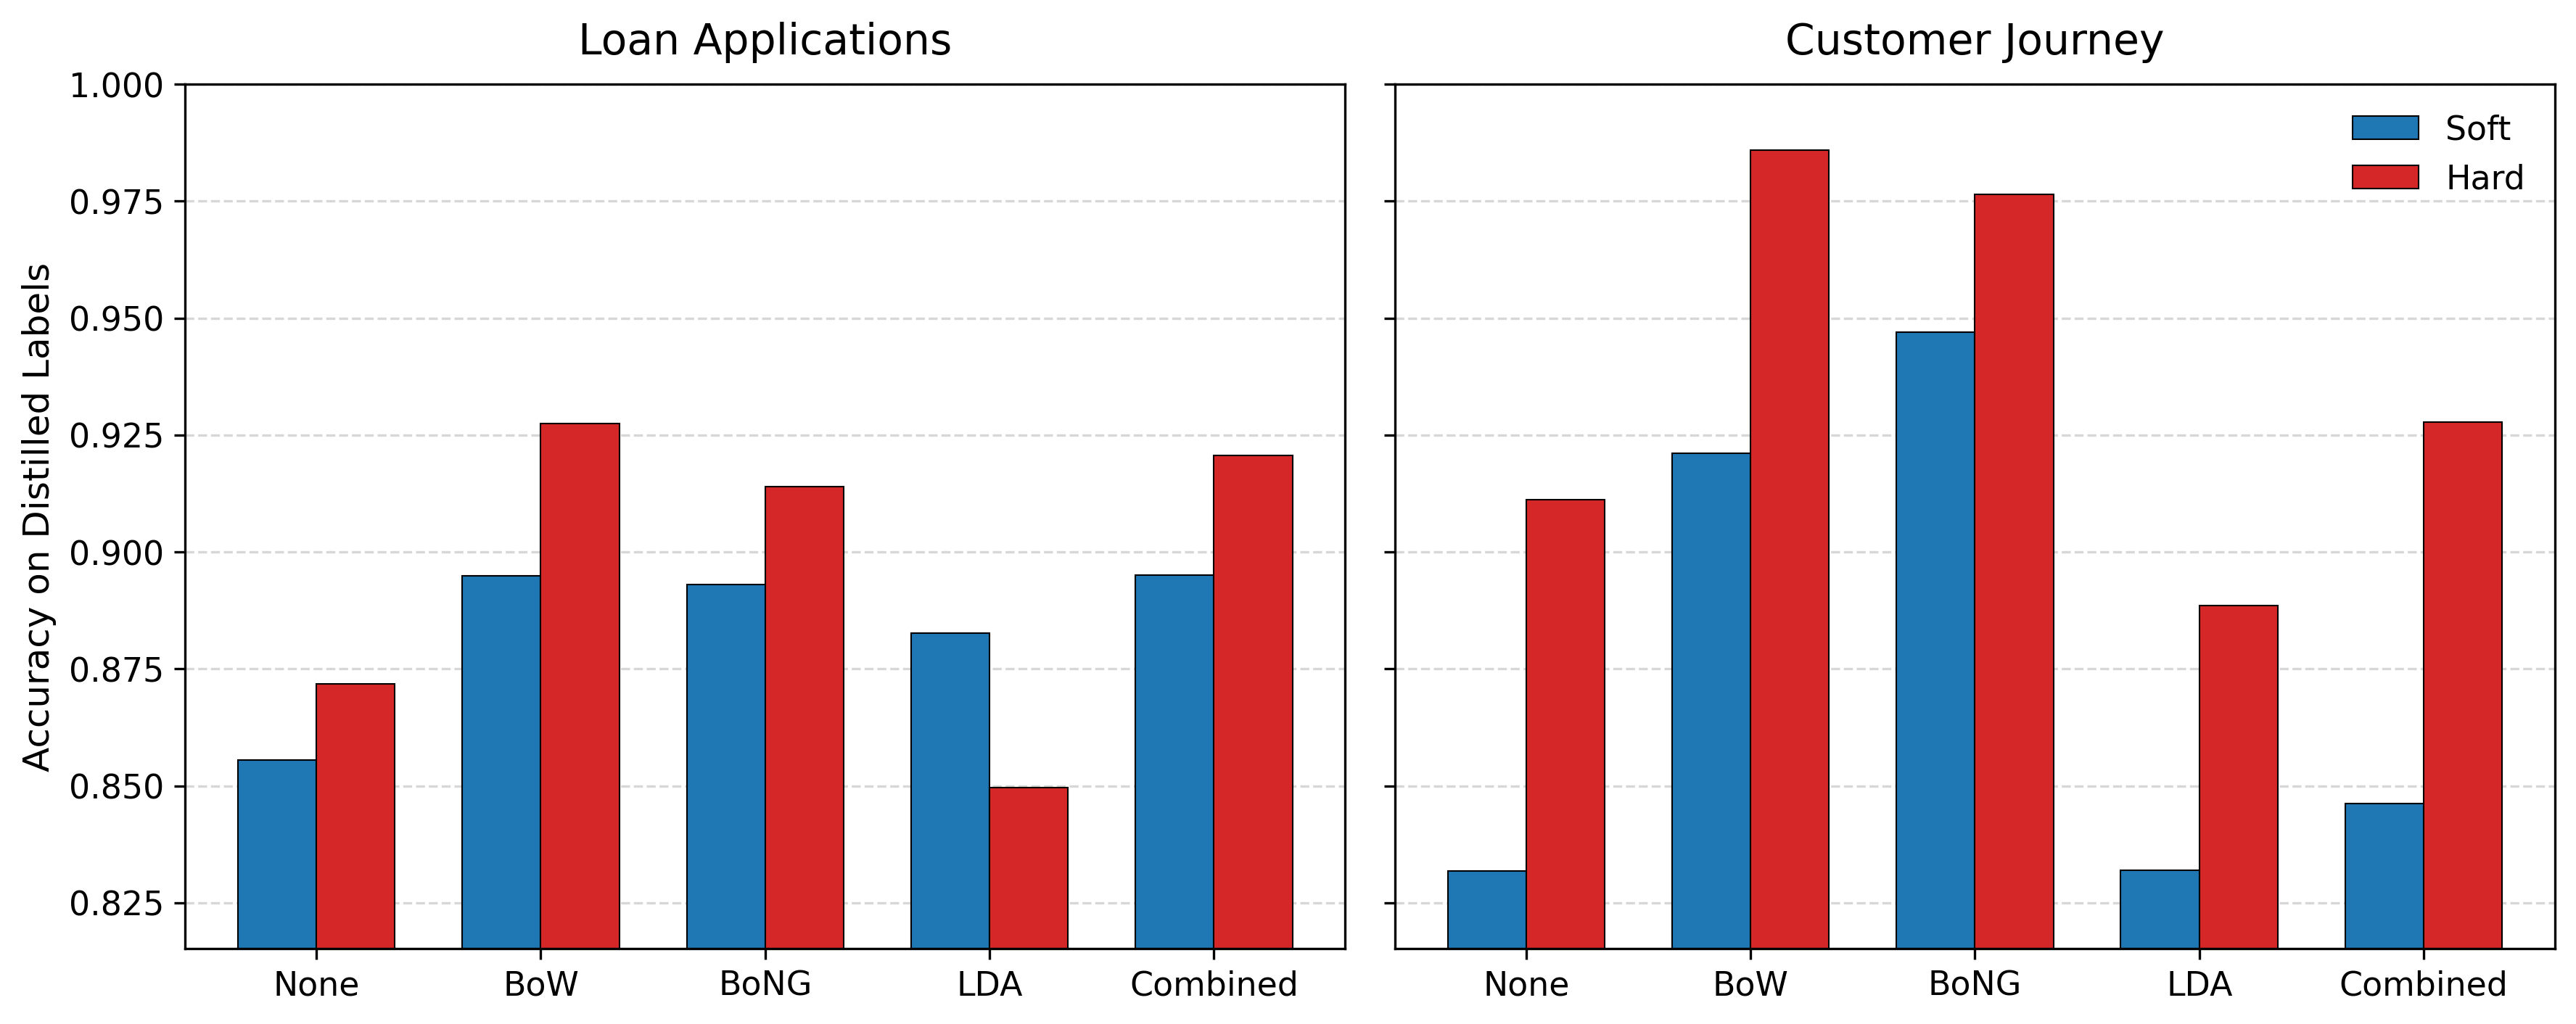

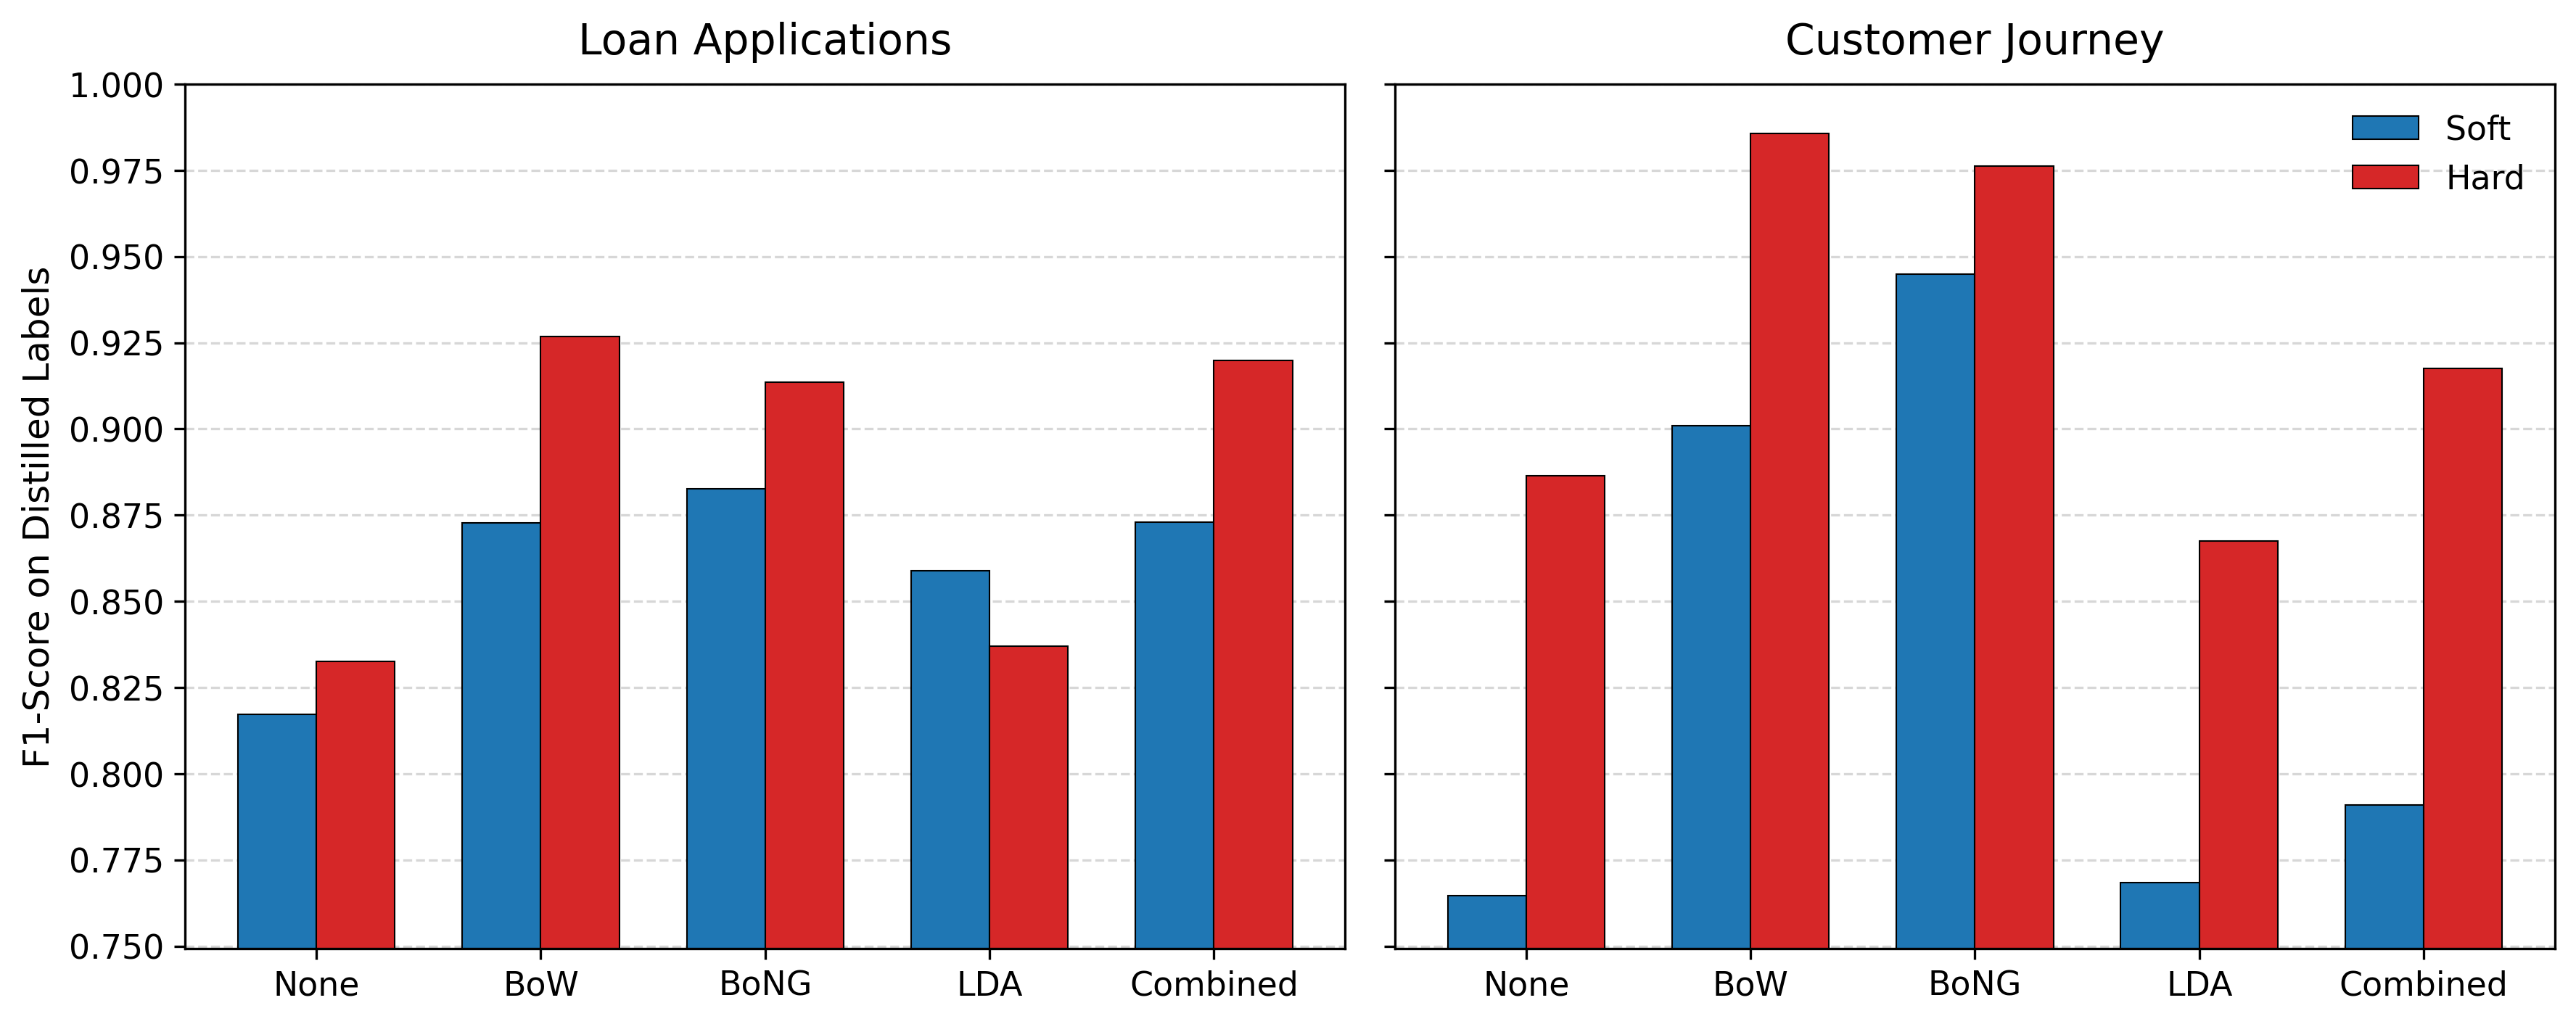

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Load your CSV
file_path = os.path.join("data", "distillation", "evaluation_results.csv")
df = pd.read_csv(file_path)

# Map model subsets to labels and group order
group_order = ["None", "BoW", "BoNG", "LDA", "Combined"]
metrics = ["con_accuracy", "con_f1_score"]

def model_label(models):
    if pd.isna(models) or models == "None":
        return "None"
    elif models == "BoW":
        return "BoW"
    elif models == "BoNG":
        return "BoNG"
    elif models == "LDA":
        return "LDA"
    else:
        return "Combined"

# Dataset list
datasets = df['folder_name'].unique()
colors = {"soft": "#1f77b4", "hard": "#d62728"}

# Professional figure settings
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "figure.dpi": 300
})

for metric in metrics:
    fig, axes = plt.subplots(1, len(datasets), figsize=(12, 5), sharey=True)
    if len(datasets) == 1:
        axes = [axes]

    save_path = os.path.join("data", "distillation", "img", f"{metric}_comparison.png")

    for i, (ax, dataset) in enumerate(zip(axes, datasets)):
        labels = "Distilled" if "con" in metric else "True"
        metric_name = "Accuracy" if "accuracy" in metric else "F1-Score"
        y_label = f"{metric_name} on {labels} Labels" 

        title = "Loan Applications" if dataset == "bpi_2012_enriched_filtered_A" else "Customer Journey"
        subdf = df[df['folder_name'] == dataset]

        soft_vals, hard_vals = [], []
        for group in group_order:
            soft_group = subdf[(subdf['text_attribute'].notnull()) & 
                               (subdf['model_names'].apply(model_label) == group) & 
                               (subdf['description'] == "soft")]
            soft_vals.append(soft_group[metric].mean() if not soft_group.empty else 0)

            hard_group = subdf[(subdf['text_attribute'].notnull()) & 
                               (subdf['model_names'].apply(model_label) == group) & 
                               (subdf['description'] == "distilled")]
            hard_vals.append(hard_group[metric].mean() if not hard_group.empty else 0)

        x = np.arange(len(group_order))
        width = 0.35

        # Draw bars
        ax.bar(x - width/2, soft_vals, width, color=colors["soft"], label="Soft", edgecolor='black', linewidth=0.5)
        ax.bar(x + width/2, hard_vals, width, color=colors["hard"], label="Hard", edgecolor='black', linewidth=0.5)

        # Axes settings
        ax.set_xticks(x)
        ax.set_xticklabels(group_order)
        ax.set_ylim(bottom=min(min(soft_vals), min(hard_vals))*0.98, top=1.0)

        # Y-axis settings: fixed step of 0.025
        y_bottom = min(min(soft_vals), min(hard_vals))*0.98
        y_ticks = np.arange(1.0, y_bottom - 1e-6, -0.025)  # subtract small epsilon to include bottom
        y_ticks = y_ticks[::-1]  # reverse to go bottom → top
        ax.set_yticks(y_ticks)

        # Y-label only on left subplot
        if i == 0:
            ax.set_ylabel(y_label)
        ax.set_title(title, pad=10)

        # Grid behind bars, stronger
        ax.set_axisbelow(True)
        ax.grid(axis='y', alpha=0.5, linestyle='--')

        # Legend only on top-right of right subplot
        if i == len(datasets)-1:
            ax.legend(frameon=False, loc='upper right')

    # Layout and save
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
